In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import random
import pandas as pd
import os
from scipy.integrate import solve_ivp, odeint
%matplotlib inline

In [3]:
def time_plot(N, S, I, beta, gamma, mu=0, v=0, 
              ax=None, focus=None, time_lim=2, **plt_kwargs):
    
    R_0 = beta*v / ((gamma+mu)*mu)
    
    if ax is None:
        ax = plt.gca()

    X, Y, Z, t = GDA(N, S, I, beta, gamma, mu=mu, v=v, time_lim=time_lim)

    ax.set_xlabel('time')
    ax.set_xlim(0, max(t))
    
    if focus == 'susceptible':
        ax.plot(t, X, label='Susceptible', color='darkblue')
        ax.set_ylim(0.9*min(X), 1.1*max(X))
        ax.set_ylabel('amount susceptible')
    elif focus == 'infected':
        ax.plot(t, Y, label='Infected', color='darkgreen')
        ax.set_ylim(0.9*min(Y), 1.1*max(Y))
        ax.set_ylabel('amount infected')
    elif focus == 'recovered':
        ax.plot(t, Z, label='Recovered', color='grey')
        ax.set_ylim(0.9*min(Z), 1.1*max(Z))
        ax.set_ylabel('amount recovered')
    else:
        ax.set_ylim(0, max([max(X), max(Y), max(Z)]))
        ax.set_ylabel('amount of individuals')
    return ax

def SIR_rates(N, X, Y, beta, gamma, mu=0, v=0):
    '''
    Determines rates of events
    '''
    R_0 = beta  / (gamma+v)
    epsilon = 1.06*mu*(R_0-1)/np.sqrt(N)
    delta = 0.0625*mu*(R_0-1)
    Z = N-(X+Y)
    return [v*N, beta*X*Y/N, gamma*Y, mu*X, mu*Y, mu*Z, delta*np.sqrt(N), epsilon*X]


def GDA(N, S, I, beta, gamma, mu=0, v=0, time_lim=2, scale=False, steps=False):
    '''
    Gillespie's Direct Algorithm
    
    Inputs:
    N: int, total population size
    S: float, fraction of susceptibles of N
    I: float, fraction of infected of N
    beta, gamma, mu, v: transmission rate, recovery rate, death rate, birth rate, 
    time_lim: number, at which time to stop the algorithm
    steps: number of time the algorithm is executed, if False will use time_lim
    
    Returns:
    X, Y, Z: lists with absolute amount of susceptible, infected and recovered individuals
    t: list with the time intervals at which events occured
    '''
    # initial values
    X = [int(S*N)]
    Y = [int(I*N)]
    Z = [int(N * (1-(S+I)))]
    N = [N]
    time = [0]

    # which event index corresponds to which dX, dY, dZ
    changes = {0:[1, 0, 0], 1:[-1, 1, 0], 2:[0, -1, 1], 3:[-1, 0, 0],
               4:[0, -1, 0], 5:[0, 0, -1], 6:None, 7:[-1, 1, 0]}
    
    if not steps:
        while time[-1] <= time_lim:
            rates = [0] + SIR_rates(N[-1], X[-1], Y[-1], beta, gamma,
                                    mu=mu, v=v)

            R_total = sum(rates)

            # time step size
            dt = -1/R_total * np.log(np.random.random())
            P = np.random.random() * R_total

            dX, dY, dZ = 0, 0, 0
            for j in range(1, len(rates)+1):
                if sum(rates[:j]) < P <= sum(rates[:j+1]):
                    if j == 7:
                        imports = random.choices([[-1, 1, 0], [0, 1, -1]], weights=[X[-1], Z[-1]])[0]
                        dX += imports[0]
                        dY += imports[1]
                        dZ += imports[2]
                    else:
                        dX += changes[j-1][0]
                        dY += changes[j-1][1]
                        dZ += changes[j-1][2]

            X += [X[-1] + dX]
            Y += [Y[-1] + dY]
            Z += [Z[-1] + dZ]
            N += [X[-1] + Y[-1] + Z[-1]]

            time += [time[-1]+dt]


        if scale:
            # returns XYZ as fractions
            X = np.array(X)/np.array(N)
            Y = np.array(Y)/np.array(N)
            Z = np.array(Z)/np.array(N)

        return X, Y, Z, time
            
    else:
        for i in range(int(steps)):
            # rates = [0, birth, transmission, recovery, death X, Y, Z]
            rates = [0] + SIR_rates(N[-1], X[-1], Y[-1], beta, gamma,
                                    mu=mu, v=v)

            R_total = sum(rates)

            # time step size
            dt = -1/R_total * np.log(np.random.random())
            P = np.random.random() * R_total

            dX, dY, dZ = 0, 0, 0
            for j in range(1, len(rates)+1):
                if sum(rates[:j]) < P <= sum(rates[:j+1]):
                    if j == 7:
                        imports = random.choices([[-1, 1, 0], [0, 1, -1]], weights=[X[-1], Z[-1]])[0]
                        dX += imports[0]
                        dY += imports[1]
                        dZ += imports[2]
                    else:
                        dX += changes[j-1][0]
                        dY += changes[j-1][1]
                        dZ += changes[j-1][2]

            X += [X[-1] + dX]
            Y += [Y[-1] + dY]
            Z += [Z[-1] + dZ]
            N += [X[-1] + Y[-1] + Z[-1]]

            time += [time[-1]+dt]

        if scale:
            # returns XYZ as fractions
            X = np.array(X)/np.array(N)
            Y = np.array(Y)/np.array(N)
            Z = np.array(Z)/np.array(N)

        return X, Y, Z, time

    
def SIR(y0, t, beta, gamma, mu, v):
    dS_dt = v - beta*y0[0]*y0[1] - mu*y0[0]
    dI_dt = beta*y0[0]*y0[1] - gamma*y0[1] - mu*y0[1]
    dR_dt = gamma*y0[1] - mu*y0[2]
    return [dS_dt, dI_dt, dR_dt]

def coupled_euler(S0, I0, beta, gamma, start=0, end=100, dt=0.01, mu=1/70, v=1/70):
    
    # indepent variable
    t = np.arange(start, end+dt, dt)
    
    # initial values
    S = [S0]
    I = [I0]
    R = [1-(S0+I0)]
    # calculate the slope
    for i in range(1, len(t)):
        dS_dt = mu - beta * S[i-1] * I[i-1] - mu*S[i-1]
        dI_dt = beta*S[i-1]*I[i-1] - gamma*I[i-1] - mu*I[i-1]
        dR_dt = gamma * I[i-1] - mu * R[i-1]

        # calculate the new y-value using the slope and dx
        S += [S[i-1] + dS_dt*dt]
        I += [I[i-1] + dI_dt*dt]
        R += [R[i-1] + dR_dt*dt]
        
    return t, np.array(S), np.array(I), np.array(R)

def phasediagram(N, beta, gamma, start=0, end=20, dt=0.01, S0 = np.linspace(0, 1, 5),
                I0 = np.linspace(0, 1, 5)[::-1], R0 = np.array([0 for i in  range(5)]),
                 immunity = False, ax=None, mu=0, v=0, mode ='GDA',
                 threshold=True, show_R_0=True, alpha=1, lw=1, color='black', **plt_kwargs):

    if ax==None:
        ax = plt.gca()

    R_0 = beta*v / ((gamma+mu)*mu)
        
    ax.scatter(S0, I0, color='black', s=10)
    
 
    # lines for R(0) = 0
    if mode == 'Euler':
        for s, i, r in zip(S0, I0, R0):
            t, S, I, R = coupled_euler(s, i, beta, gamma, start=start, end=end, 
                                       dt=dt, mu=mu, v=v)
            ax.plot(S, I, color=color, alpha=alpha, lw=lw) 
    elif mode == 'GDA':
        for s, i, r in zip(S0, I0, R0):
            X, Y, Z, t = GDA(N, s, i, beta, gamma, mu=mu, v=v, time_lim=end, scale=True)
            ax.plot(X, Y, color=color, alpha=alpha, lw=lw)

    # lines for R(0) > 0
    if immunity:
        if mode == 'Euler':
            s0 = np.arange(1.1/R_0, 1, 0.1)
            i0 = np.array([0.001 for s in s0])
            r0 = np.array([1-(s+i) for s, i in zip(s0, i0)])
            
            # plots initial conditions
            ax.scatter(s0, i0, color='black', s=10) 
            
            for s, i, r in zip(s0, i0, r0):
                t, S, I, R = coupled_euler(s, i, beta, gamma, start=start, end=end, dt=dt, mu=mu, v=v)
                ax.plot(S, I, color=color, alpha=alpha, lw=lw)
                
        elif mode == 'GDA':
            s0 = np.arange(1.1/R_0+0.05, 1, 0.1)
            i0 = np.array([0.001 for s in s0])
            r0 = np.array([1-(s+i) for s, i in zip(s0, i0)])
            
            # plots initial condition
            ax.scatter(s0, i0, color='black', s=10) 
            
            for s, i, r in zip(s0, i0, r0):
                X, Y, Z, t = GDA(N, s, i, beta, gamma, mu=mu, v=v, time_lim=end, scale=True)
                ax.plot(X, Y, color=color, alpha=alpha, lw=lw)
                
                
                
    # line where S+I=1
    ax.plot(np.linspace(0, 1), np.linspace(0, 1)[::-1], color = 'grey')
    
    # show value of R_0
    if show_R_0:
        anchored_text = AnchoredText(rf'$R_0 = {round(R_0,2)}$', loc=1, prop=dict(size=5))
        ax.add_artist(anchored_text)
    
    # show epidemic threshold
    if R_0 > 1:
        if threshold:
                ax.vlines(1/R_0, 0, -1/R_0+1, linestyle='--', colors = 'grey')
                ax.text(1/R_0-0.03, -1/R_0+1 + 0.05, r'$1 / R_0$')

    ax.set_xlabel('susceptibles')
    ax.set_ylabel('infected')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    return ax

Stochastic resonance

In [ ]:
N = 1e5
S = 0.1
I = 2.5e-4
beta = 520
gamma = 365.25/7
mu = 1/70
v = mu
time_lim = 50
dt = 1
t = np.arange(0, time_lim+dt, dt)

time, s, i, r = coupled_euler(S, I, beta, gamma, end=time_lim, mu=mu, v=v, dt=0.0001)

XYZ = odeint(SIR, [S, I, 1-(S+I)], t, args=(beta, gamma, mu, v))

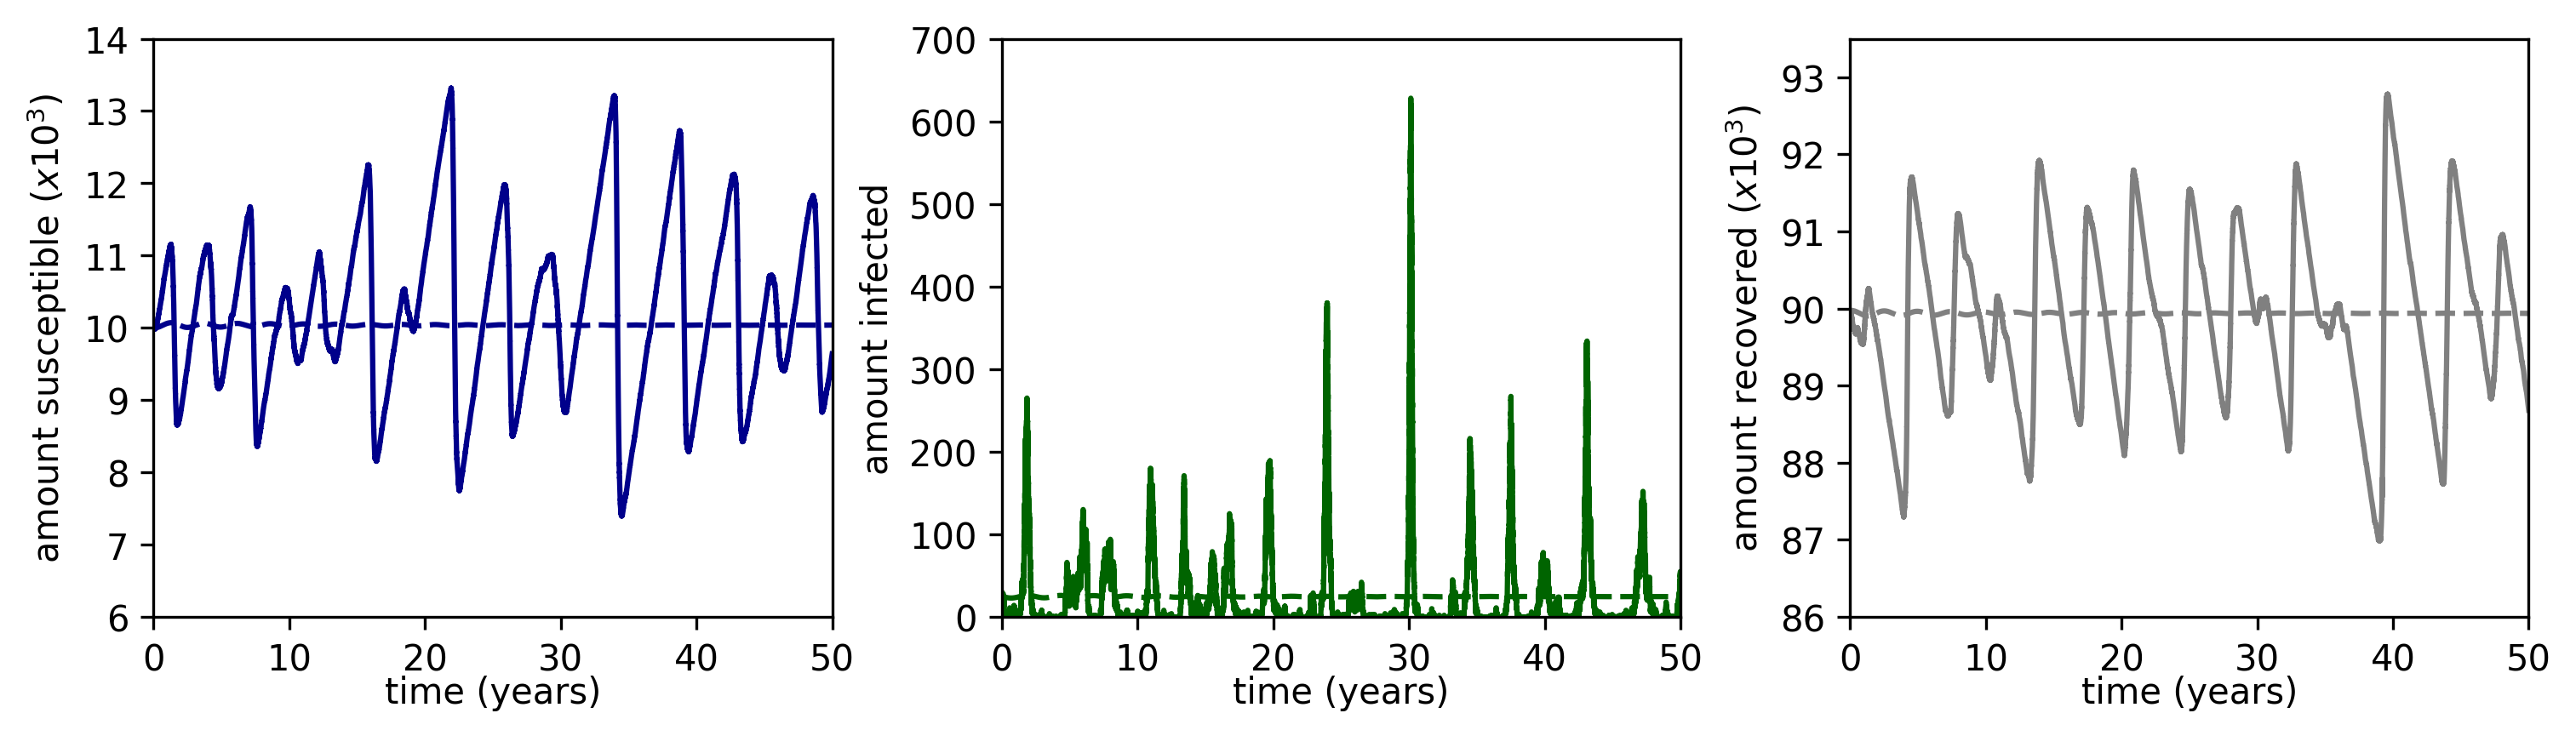

In [245]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 3), dpi=300)

ax1 = time_plot(N, S, I, beta, gamma, mu=mu, v=mu,
         focus='susceptible', time_lim=time_lim, ax=ax1)
ax1.plot(time, s*N, '--', color='darkblue')
ax1.set_xlabel('time (years)')
ax1.set_ylabel('amount susceptible $(x 10^3)$')
ax1.set_yticks(np.arange(6000, 14001, 1000))
ax1.set_yticklabels(np.arange(6, 14.1, 1, dtype=int))
ax1.set_ylim(6000, 14000)
ax1.xaxis.set_label_coords(0.5, -0.1)

ax2 = time_plot(N, S, I, beta, gamma, mu=mu, v=mu,
         focus='infected', time_lim=time_lim, ax=ax2)
# ax2.plot(t, XYZ[:, 1]*N, '--', color='darkgreen')
ax2.plot(time, i*N, '--', color='darkgreen')
ax2.set_xlabel('time (years)')
ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.set_ylim(0, 700)

ax3 = time_plot(N, S, I, beta, gamma, mu=mu, v=mu,
         focus='recovered', time_lim=time_lim, ax=ax3)
# ax3.plot(t, XYZ[:, 2]*N, '--', color='darkgrey')
ax3.plot(time, r*N, '--', color='grey')
ax3.set_xlabel('time (years)')
ax3.set_ylabel('amount recovered $(x 10^3)$')
ax3.set_yticks(np.arange(86000, 93001, 1000))
ax3.set_yticklabels(np.arange(86, 93.1, 1, dtype=int))
ax3.set_ylim(86000, 93500)
ax3.xaxis.set_label_coords(0.5, -0.1)
# ax3.set_ylim()

plt.subplots_adjust(wspace=0.25)
plt.savefig('oscillations.png', dpi=300)
plt.show()

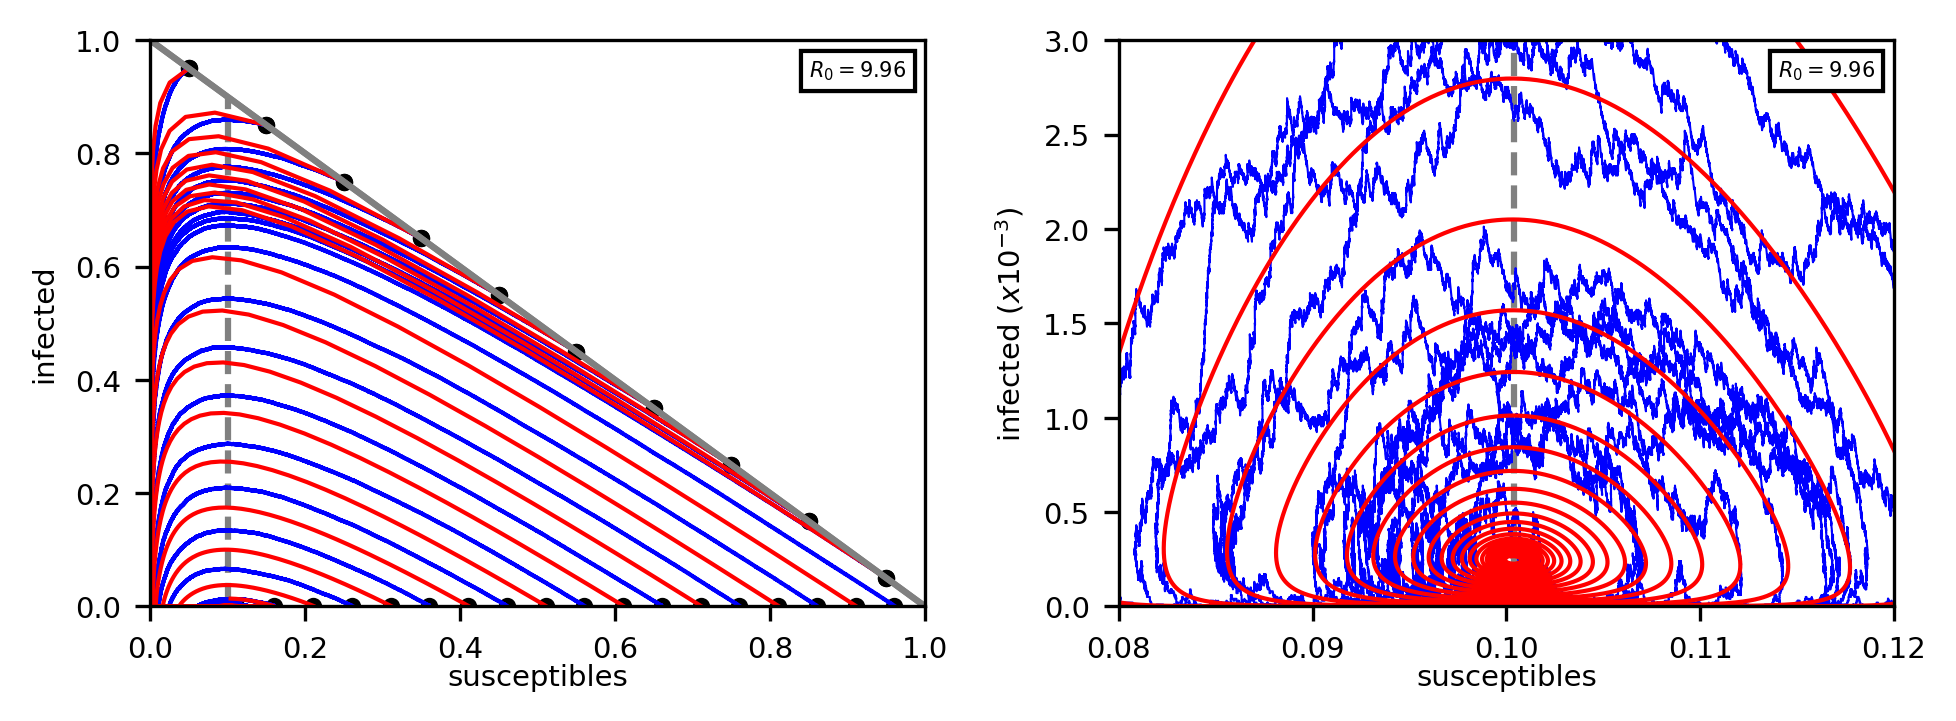

In [11]:
N = 1e5
S = 0.1
I = 2.5e-4
beta = 520
gamma = 365.25/7
mu = 1/70
v = 1/70
R_0 = beta*v / ((gamma+mu)*mu)
I0=np.arange(0.95, 0, -0.1)
S0=np.arange(0.05, 1, 0.1)
R0=[0 for i in I0]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(7.5, 2.5), dpi=300)

ax1 = phasediagram(N, beta, gamma, mu=mu, v=v, mode='GDA', S0=S0, I0=I0,
             R0=R0, immunity=True, end=10, ax=ax1, color='blue', threshold=False)
ax1 = phasediagram(N, beta, gamma, mu=mu, v=v, mode='Euler', dt=0.001, threshold=False,
                   immunity=True, end=10, ax=ax1, color='red', S0=S0, I0=I0, R0=R0)

ax2 = phasediagram(N, beta, gamma, mu=mu, v=v, mode='GDA', S0=[0.6], I0=[0.0001], lw=0.5,
             R0=[1-0.6-0.0001], immunity=False, ax=ax2, threshold=False, color='blue', alpha=1, end=50)
ax2 = phasediagram(N, beta, gamma, mu=mu, v=v, mode='Euler', dt=0.001, immunity=False, R0=[1-0.6-0.0001],
                   ax=ax2, threshold=False, color='red', alpha=1, S0=[0.6], I0=[0.001], end=100, lw=1)

# plot epidemic threshold
ax2.vlines(1/R_0, 0, 3e-3, linestyle='--', color='grey')
ax1.vlines(1/R_0, 0, -1/R_0+1, linestyle='--', color ='grey')

ax2.set_xlim(0.08, 0.12)
ax2.set_ylim(0, 3e-3)
ax2.set_yticks(np.arange(0, 0.0031, 0.0005))
ax2.set_yticklabels(np.arange(0, 3.1, 0.5))
ax2.set_xticks(np.arange(0.08, 0.121, 0.01))
size = 7

ax1.tick_params(axis='both', which='major', labelsize=size)
ax1.xaxis.set_label_coords(0.5, -0.1)
ax2.tick_params(axis='both', which='major', labelsize=size)
ax2.xaxis.set_label_coords(0.5, -0.1)

ax1.set_ylabel('infected', fontsize=size)
ax2.set_ylabel('infected $(x10^{-3})$', fontsize=size)
ax1.set_xlabel('susceptibles', fontsize=size)
ax2.set_xlabel('susceptibles', fontsize=size)

plt.subplots_adjust(wspace=0.25)
plt.savefig('transient phasediagram.png', dpi=300)
plt.show()

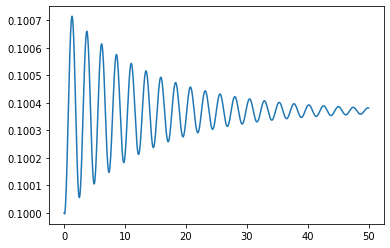

In [7]:
plt.plot(time, s)
plt.show()

In [9]:
N = 1e5
S = 0.4
I = 0.05
beta = 520
gamma = 365.25/7
mu = 1/70
v = mu
time_lim = 50
dt = 0.1
t = np.arange(0, time_lim+dt, dt)

XYZ = odeint(SIR, [S, I, 1-(S+I)], t, args=(beta, gamma, mu, v))
time, s, i, r = coupled_euler(S, I, beta, gamma, end=time_lim, mu=mu, v=v, dt=0.0001)

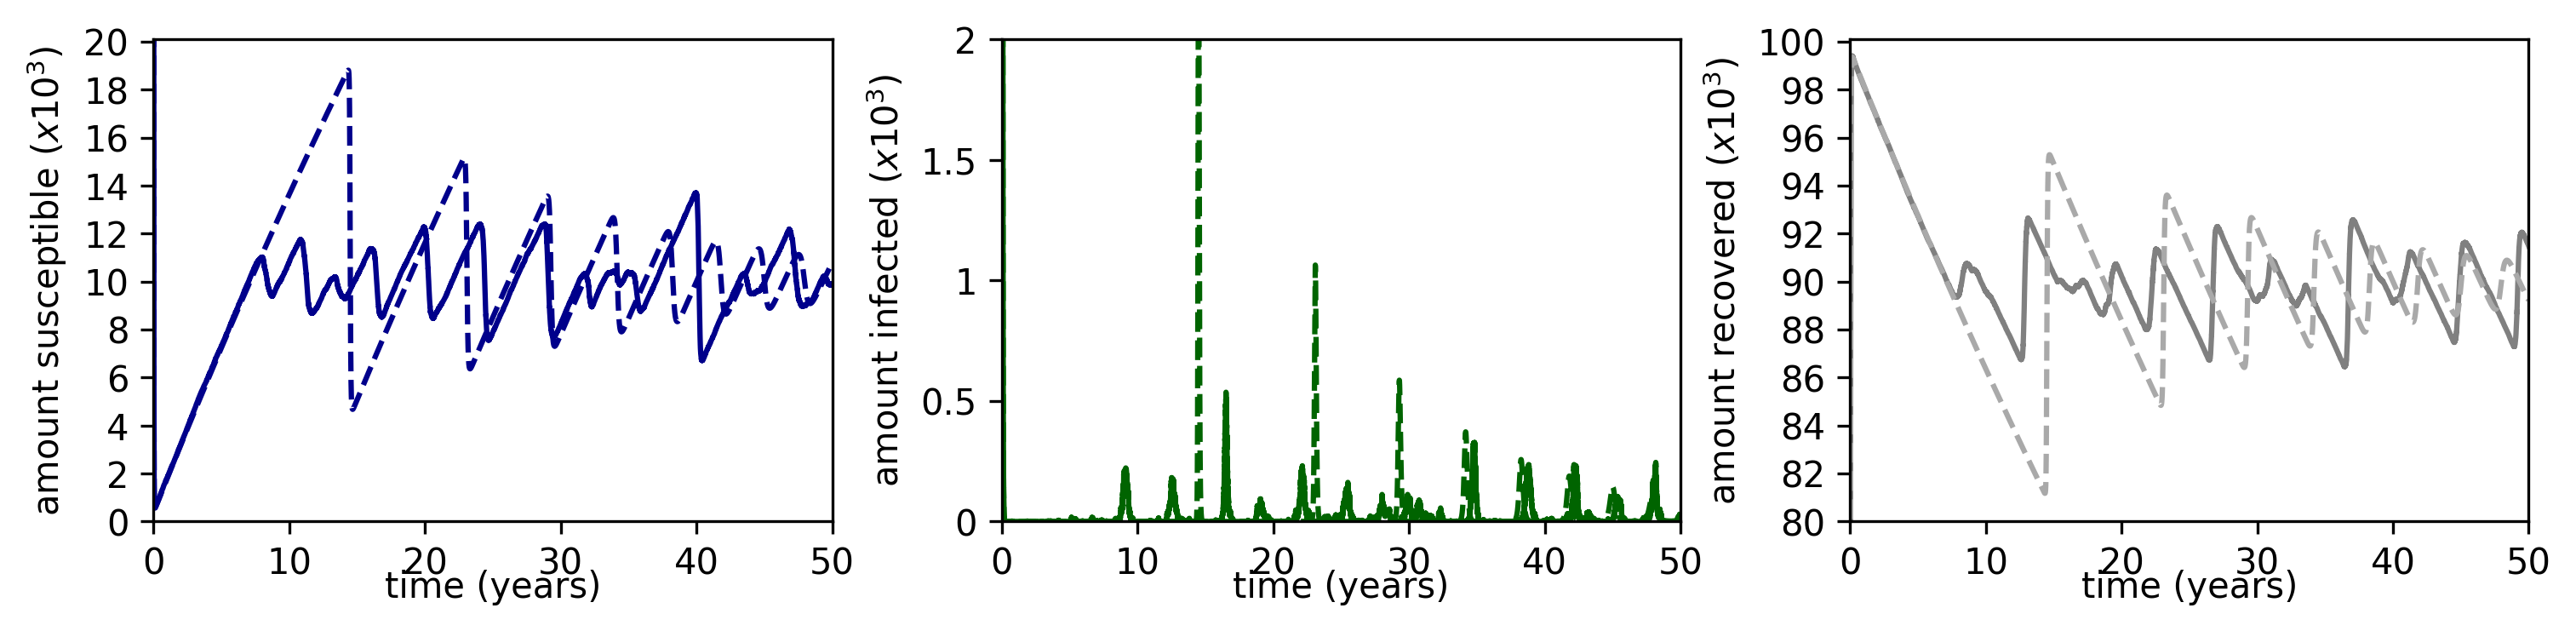

In [10]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 2.5), dpi=300)

ax1 = time_plot(N, S, I, beta, gamma, mu=mu, v=mu,
         focus='susceptible', time_lim=time_lim, ax=ax1)
ax1.plot(time, s*N, '--', color='darkblue')
ax1.set_xlabel('time (years)')
ax1.set_ylabel('amount susceptible $(x 10^3)$')
ax1.set_yticks(np.arange(0, 20001, 2000))
ax1.set_yticklabels(np.arange(0, 20.1, 2, dtype=int))
ax1.xaxis.set_label_coords(0.5, -0.1)
ax1.set_ylim(0, 20100)
ax1.set_xticks(np.arange(0, 51, 10, dtype=int))

ax2 = time_plot(N, S, I, beta, gamma, mu=mu, v=mu,
         focus='infected', time_lim=time_lim, ax=ax2)
ax2.plot(time, i*N, '--', color='darkgreen')
ax2.set_xlabel('time (years)')
ax2.set_ylabel('amount infected $(x10^3)$')
ax2.set_yticks([0, 500, 1000, 1500, 2000, 2500])
ax2.set_yticklabels([0, 0.5, 1, 1.5, 2, 2.5])
ax2.set_xticks(np.arange(0, 51, 10, dtype=int))
ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.set_ylim(0, 2000)

ax3 = time_plot(N, S, I, beta, gamma, mu=mu, v=mu,
         focus='recovered', time_lim=time_lim, ax=ax3)
ax3.plot(time, r*N, '--', color='darkgrey')
ax3.set_xlabel('time (years)')
ax3.set_ylabel('amount recovered $(x 10^3)$')
ax3.set_xticks(np.arange(0, 51, 10, dtype=int))
ax3.set_yticks(np.arange(80000, 100001, 2000))
ax3.set_yticklabels(np.arange(80, 100.1, 2, dtype=int))
ax3.set_ylim(80000, 100100)
ax3.xaxis.set_label_coords(0.5, -0.1)

plt.subplots_adjust(wspace=0.25)
plt.savefig('transients.png', dpi=300)
plt.show()

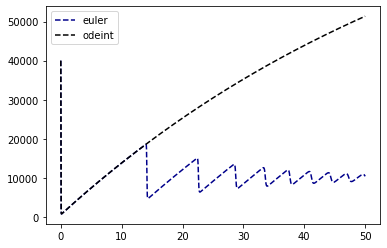

In [309]:
# difference between euler method and odeint

dt = 0.0001
t = np.arange(0, time_lim+dt, dt)

XYZ = odeint(SIR, [S, I, 1-(S+I)], t, args=(beta, gamma, mu, v))
time, s, i, r = coupled_euler(S, I, beta, gamma, end=time_lim, mu=mu, v=v, dt=dt)

plt.plot(time, s*N, '--', color='darkblue', label='euler')
plt.plot(t, XYZ[:, 0]*N, '--', color='black', label='odeint')
plt.legend()
plt.show()

Extinction based on population size

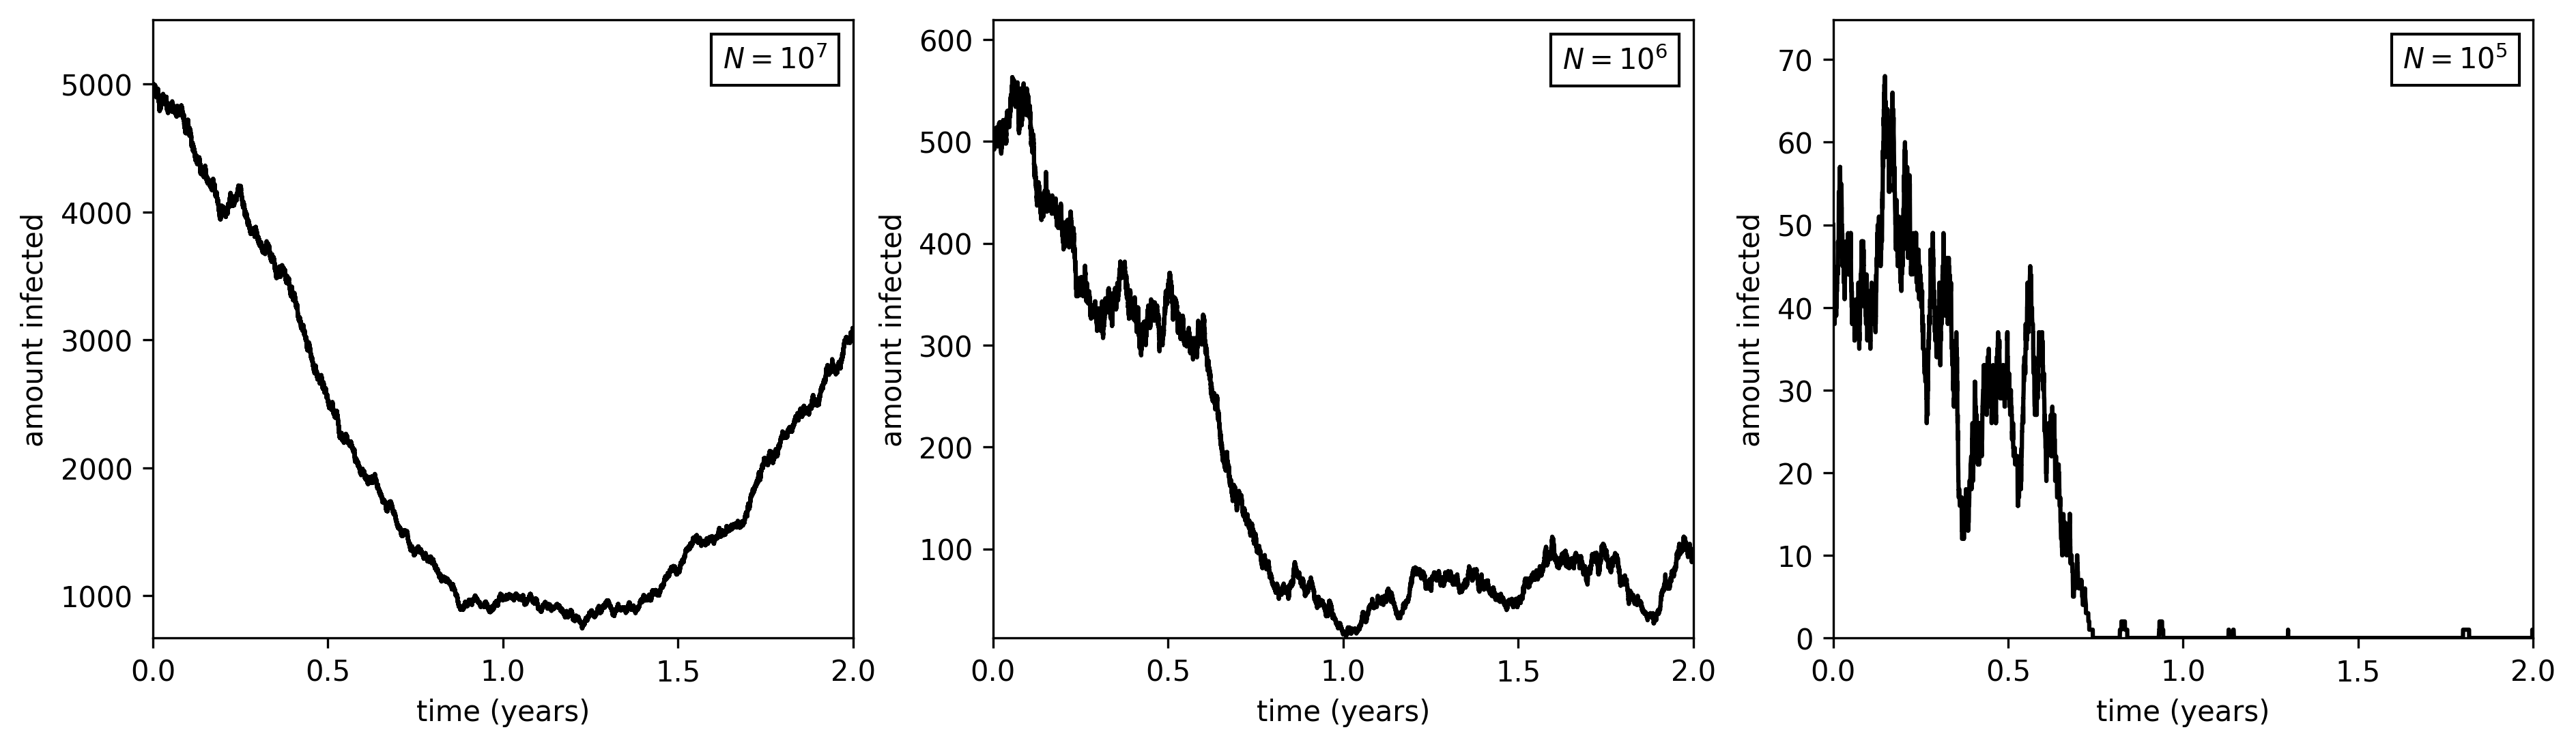

In [3]:
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15, 4), dpi=300)

ax1 = time_plot(1e7, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
        focus='infected', ax=ax1)
anchored_text = AnchoredText(rf'$N = 10^7$', loc=1)
ax1.add_artist(anchored_text)
ax1.set_xlabel('time (years)')

ax2 = time_plot(1e6, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
         focus='infected', ax=ax2)
anchored_text = AnchoredText(rf'$N = 10^6$', loc=1)
ax2.add_artist(anchored_text)
ax2.set_xlabel('time (years)')

ax3 = time_plot(1e5, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
         focus='infected', ax=ax3)
anchored_text = AnchoredText(rf'$N = 10^5$', loc=1)
ax3.add_artist(anchored_text)
ax3.set_xlabel('time (years)')

plt.savefig('popsize_extinctions.png', dpi=300)
plt.show()

In [263]:
pop_size = np.arange(10**5, 10**6+1, 0.5*10**5, dtype=int)
gamma = 365.25/7
mu = 1/70
beta = 520
S0 = 0.1
I0 = 2.5e-4
time_lim = 10

map_name = 'extinction data'
all_Y = []
avg_ext = {}
for N in pop_size:
    num_ext = []
    inf = {}
    max_time = 0
    for i in range(100):
        X, Y, Z, t = GDA(N, S0, I0, beta, gamma, mu=mu, v=mu, time_lim=time_lim)
        
        if len(Y) > max_time:
            max_time = len(Y)
        
        num_ext += [len([y for y in Y if y==0])/time_lim]
        inf[i] = Y
    
    # add nans so all runs have the same length
    for k, v in inf.items():
        new_v = v + [float('NaN') for i in range(max_time - len(v))]
        inf[k] = new_v
        
    if not os.path.exists(map_name):
        os.makedirs(map_name)
    
    inf = pd.DataFrame(inf)
    inf.to_csv(rf'C:\Users\guido\master CLS\introduction to cls\assignment 2\{map_name}\inf_data{N}.csv', index=False)
    
    avg_ext[N] = [np.mean(num_ext)]
    all_Y += [Y]

# save mean # extinctions per pop size
avg_ext = pd.DataFrame(avg_ext)
avg_ext.to_csv('extinctions.csv', index=False)

In [294]:
import scipy.stats as st

avg_ext= []
stdev_ext = []
CI_ext = []
for file in os.listdir('extinction data'):
    path = r'C:\Users\guido\master CLS\introduction to cls\assignment 2\extinction data'
    data = pd.read_csv(path + '/' + file)
    
    # amount of extinctions for 10 runs per year
    ext_allruns = []
    for run, col in data.iteritems():
        extinctions = 0
        for i in range(1, len(col)):
            if col[i-1]== 0 and col[i] != 0:
                extinctions += 1
        ext_allruns += [extinctions/time_lim]
#         ext_allruns += [len([y for y in col if y==0])/time_lim]
        
    # average extinctions over 10 runs 
    avg_ext += [np.mean(ext_allruns)]
    stdev_ext += [np.std(ext_allruns)]
    CI_ext += [st.t.interval(alpha=0.95, df=len(ext_allruns)-1,
                             loc=np.mean(ext_allruns), scale=st.sem(ext_allruns))]

Variations plotted as the mean and the standard deviations

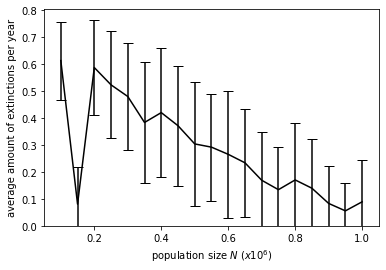

In [296]:
norm_N = pop_size/10**6
plt.plot(norm_N, avg_ext, color='black')
plt.errorbar(norm_N, avg_ext, yerr=stdev_ext, fmt=' ', ecolor='black', capsize=5)
plt.xlabel('population size $N \; (x10^6)$')
plt.ylabel('average amount of extinctions per year')
plt.xlim(0.05, 1.05)
plt.ylim(0, None)
# plt.ylim(min(avg_ext), max(avg_ext))
plt.savefig('extinctions.png', dpi=300)
plt.show()

In [279]:
# abonded CCS code

mu = 0.02
v = 0.02
num_params = 100
time_lim = 1

# log10 spaced numbers in [10, 700]
gamma = np.logspace(1, np.log10(700), num_params)

R0 = np.logspace(0, np.log10(20), num_params)
beta = R0 * (gamma+v)
S = 1/R0
I = mu/beta * (R0-1)
N = np.logspace(2, 6, num_params, dtype=int)

CCS = {}
for i in range(num_params):
    for j in range(num_params):
        X, Y, Z, t = GDA(N[i], S[i], I[i], beta[j], gamma[i], mu=mu, v=v, time_lim=time_lim)
        extinctions = len([y for y in Y if y==0])
        if extinctions <= 1:
              pass

[   100    107    114    123    132    141    151    162    174    187
    200    215    231    247    265    284    305    327    351    376
    403    432    464    497    533    572    613    657    705    756
    811    869    932   1000   1072   1149   1232   1321   1417   1519
   1629   1747   1873   2009   2154   2310   2477   2656   2848   3053
   3274   3511   3764   4037   4328   4641   4977   5336   5722   6135
   6579   7054   7564   8111   8697   9326  10000  10722  11497  12328
  13219  14174  15199  16297  17475  18738  20092  21544  23101  24770
  26560  28480  30538  32745  35111  37649  40370  43287  46415  49770
  53366  57223  61359  65793  70548  75646  81113  86974  93260 100000]


Variability and (co)variances

In [17]:
N = 1e5
S = 0.5
I = 0.001
beta = 520
gamma = 365.25/7
mu = 1/70

all_X, all_Y, all_Z, all_t = [], [], [], []

for i in range(10):
    X, Y, Z, t = GDA(N, S, I, beta, gamma, mu=mu, v=mu, steps=int(5e5))
    all_X += [X]
    all_Y += [Y]
    all_Z += [Z]
    all_t += [t]

# transform list to 2d array
all_X = np.array(all_X)
all_Y = np.array(all_Y)
all_Z = np.array(all_Z)
all_t = np.array(all_t)

# calculate the mean of each column
X_mean = np.mean(all_X, axis=0)
Y_mean = np.mean(all_Y, axis=0)
Z_mean = np.mean(all_Z, axis=0)
t_mean = np.mean(all_t, axis=0)

# calculate the variance along each column
X_var = np.var(all_X, axis=0)
Y_var = np.var(all_Y, axis=0)
Z_var = np.var(all_Z, axis=0)

445.8


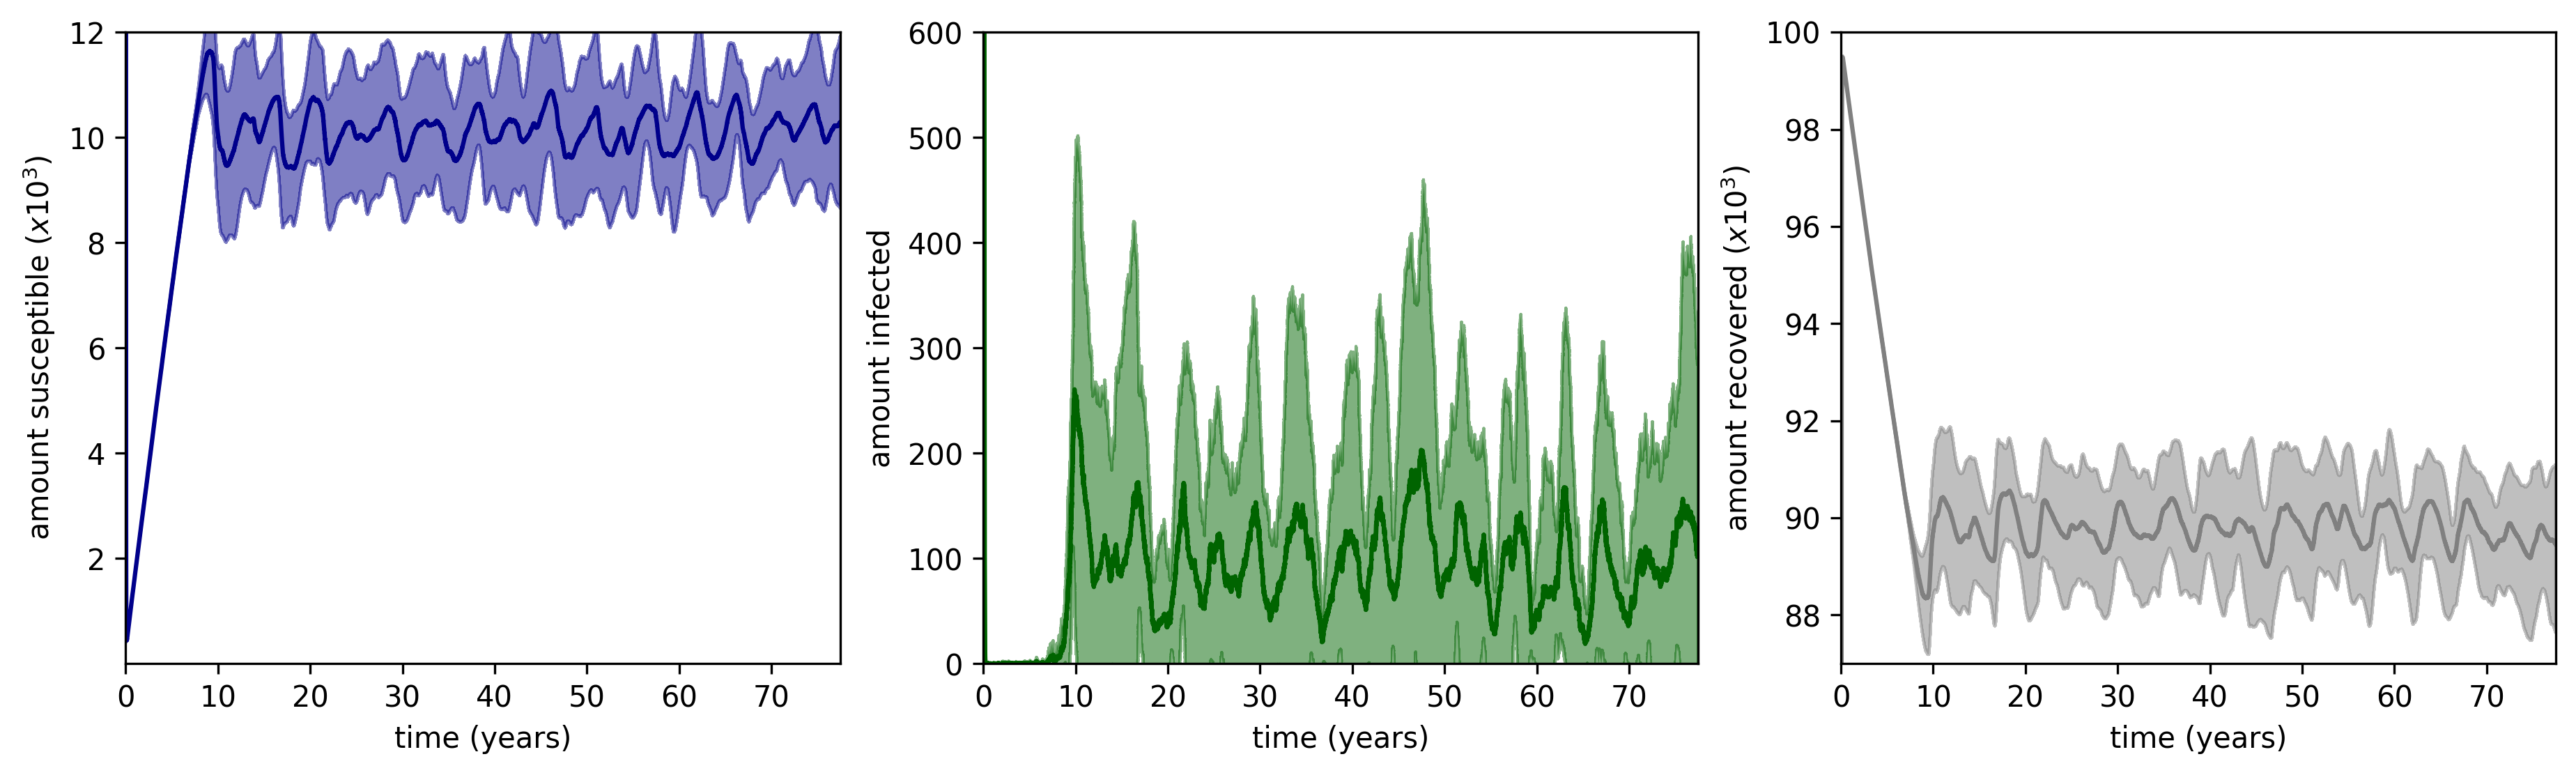

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 4), dpi=300)

ax1.plot(t_mean, X_mean, color='darkblue')
ax1.fill_between(t_mean, X_mean-np.std(all_X, axis=0), X_mean+np.std(all_X, axis=0), color='darkblue', alpha=0.5)
ax1.set_xlabel('time (years)')
ax1.set_ylabel('amount susceptible $(x10^3)$')
ax1.set_yticks(np.arange(2000, 12001, 2000))
ax1.set_yticklabels([2, 4, 6, 8, 10, 12])
ax1.set_xlim(0, max(t_mean))
ax1.set_ylim(0, 12000)

ax2.plot(t_mean, Y_mean, color='darkgreen', label='infected')
ax2.fill_between(t_mean, Y_mean-np.std(all_Y, axis=0), Y_mean+np.std(all_Y, axis=0), color='darkgreen', alpha=0.5)
ax2.set_xlabel('time (years)')
ax2.set_ylabel('amount infected')
ax2.set_ylim(0, 600)
ax2.set_xlim(0, max(t_mean))

ax3.plot(t_mean, Z_mean, color='grey', label='recovered')
ax3.fill_between(t_mean, Z_mean-np.std(all_Z, axis=0), Z_mean+np.std(all_X, axis=0), color='grey', alpha=0.5)
ax3.set_yticks(np.arange(88000, 100001, 2000))
ax3.set_yticklabels(np.arange(88, 101, 2, dtype=int))
ax3.set_ylim(87000, 100000)
ax3.set_ylabel('amount recovered $(x10^3)$')
ax3.set_xlabel('time (years)')
ax3.set_xlim(0, max(t_mean))

plt.savefig('devations_GDA.png', dpi=300)
plt.show()

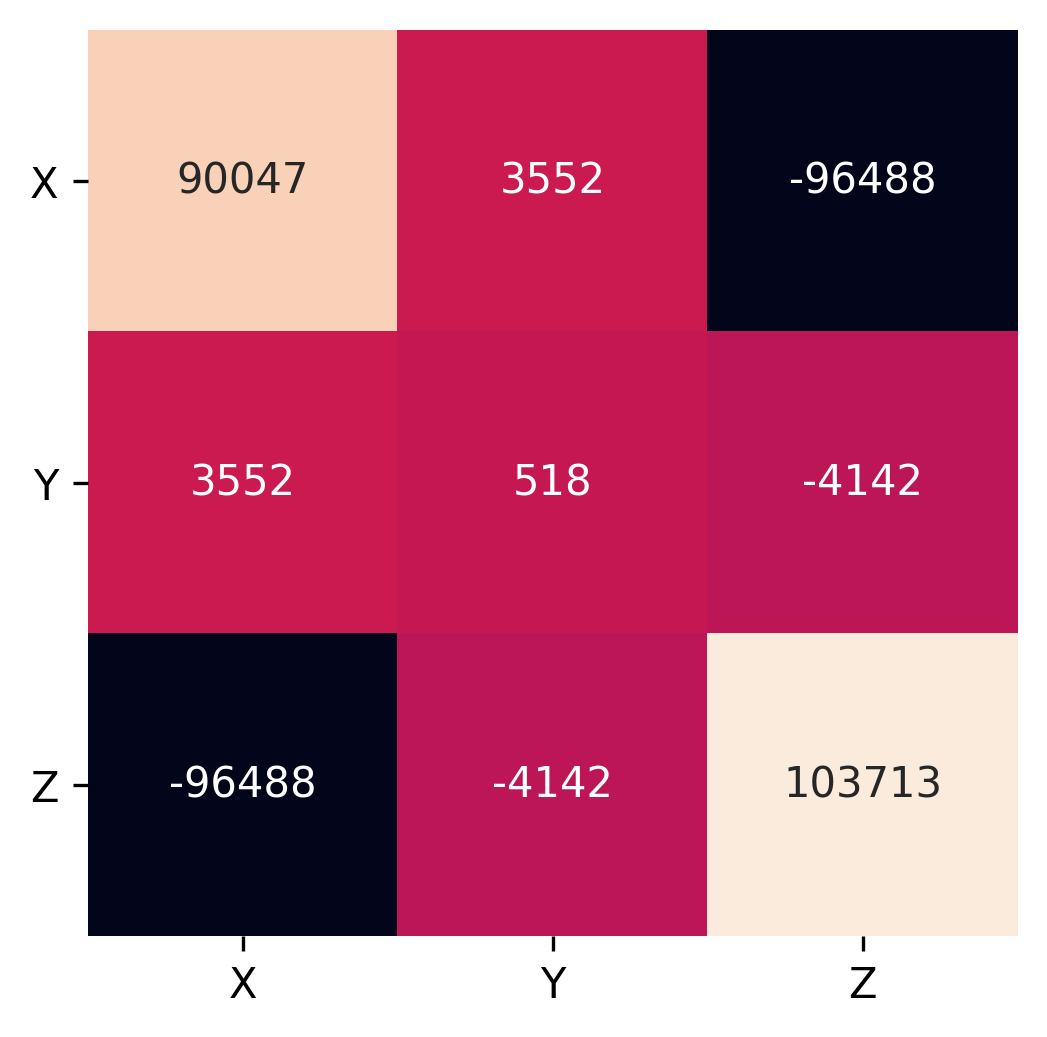

In [68]:
cov_SI = np.cov([X_mean, Y_mean, Z_mean])
cov_SI = np.array(cov_SI, dtype=int)

ylabels = ['X', 'Y', 'Z']
xlabels = ['susceptible', 'infected', 'recovered']

fig = plt.figure(figsize=(4, 4), dpi=300)
sns.heatmap(cov_SI, annot=True, fmt='g', xticklabels=ylabels, yticklabels=ylabels,
            cbar=False)
plt.yticks(rotation=0) 
plt.savefig('cov_matrix.png', dpi=300)
plt.show()

In [52]:
N = 1e6
S = np.arange(0, 1, 0.1)
I = S0[::-1]
n = len(I)
beta = 520
gamma = 365.25/7
mu = 1/70

all_cov = []

for s, i in zip(S, I):

    all_X, all_Y, all_Z, all_t = [], [], [], []

    for i in range(10):
        X, Y, Z, t = GDA(N, s, i, beta, gamma, mu=mu, v=mu, steps=int(1e5))
        all_X += [X]
        all_Y += [Y]
        all_Z += [Z]
        all_t += [t]

    # transform list to 2d array
    all_X = np.array(all_X)
    all_Y = np.array(all_Y)
    all_Z = np.array(all_Z)
    all_t = np.array(all_t)

    # calculate the variance along each column
    X_mean = np.mean(all_X, axis=0)
    Y_mean = np.mean(all_Y, axis=0)
    Z_mean = np.mean(all_Z, axis=0)
    
    # calculate the covariance matrix
    if s == 0:
        all_cov += [np.cov([X_mean, Y_mean, Z_mean])]
    else:
        all_cov += np.cov([X_mean, Y_mean, Z_mean])
        
all_cov = [ele/n for ele in all_cov]

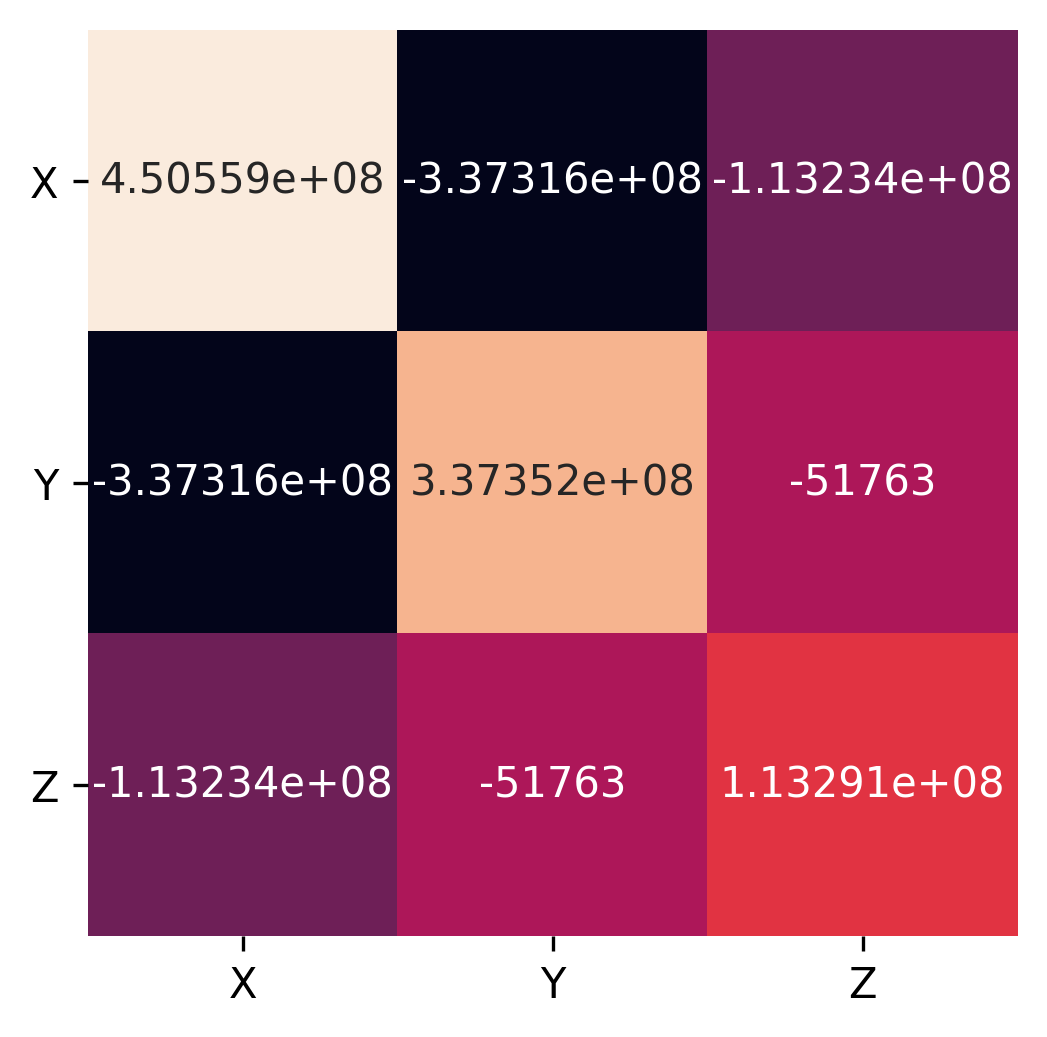

In [69]:
# average covariance for multiple initial conditions

cov_SI = np.array(all_cov[0], dtype=int)

ylabels = ['X', 'Y', 'Z']
xlabels = ['susceptible', 'infected', 'recovered']

fig = plt.figure(figsize=(4, 4), dpi=300)
sns.heatmap(cov_SI, annot=True, fmt='g', xticklabels=ylabels, yticklabels=ylabels,
            cbar=False)
plt.yticks(rotation=0) 
plt.savefig('cov_matrix_all_SI.png', dpi=300)
plt.show()